In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import opendatasets as od
import time
import cv2
import os

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [11]:
Train_data_dir = "/Users/gihansavinda/Desktop/Mini_Project/5/Animal Classification/Dataset/train"
Test_data_dir = "/Users/gihansavinda/Desktop/Mini_Project/5/Animal Classification/Dataset/test"

classes = os.listdir(Train_data_dir)
print("Classes in the training data directory:")
for class_name in classes:
    print(class_name)

Classes in the training data directory:
Dogs
Wild_Boar
Cats


In [12]:
Train_data = tf.keras.utils.image_dataset_from_directory(Train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.2,
                                                         seed=42)

Validation_data = tf.keras.utils.image_dataset_from_directory(Train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.2,
                                                         seed=42)

Test_data = tf.keras.utils.image_dataset_from_directory(Test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)


Found 4257 files belonging to 3 classes.
Using 3406 files for training.
Found 4257 files belonging to 3 classes.
Using 851 files for validation.
Found 186 files belonging to 3 classes.


In [13]:
data_augmentation = tf.keras.Sequential(
    [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(128, 128, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
]
)

In [14]:
'''pretrained_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3),
    pooling='max'
)

for layer in pretrained_model.layers:
    layer.trainable = False'''


pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3))

for layer in pretrained_model.layers:
    layer.trainable = False

In [18]:

model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())


model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu'))


model.add(tf.keras.layers.Dense(3, activation='softmax'))


In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [21]:
start_time = time.time()

history = model.fit(
    Train_data,
    epochs=100,
    validation_data=Validation_data
)

end_time = time.time()

Epoch 1/100
 33/107 [========>.....................] - ETA: 13s - loss: 0.1039 - accuracy: 0.9725

KeyboardInterrupt: 

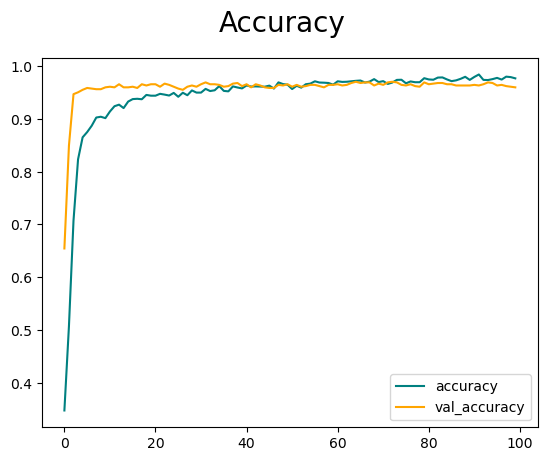

In [22]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')

fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')

fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

In [15]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.CategoricalAccuracy()

In [16]:
for batch in Test_data.as_numpy_iterator():
    x, y = batch
    y_one_hot = tf.one_hot(y, depth=3)
    yhat = model.predict(x)
    precision.update_state(y_one_hot, yhat)
    recall.update_state(y_one_hot, yhat)
    accuracy.update_state(y_one_hot, yhat)


1/1 [==============================] - 1s 532ms/step


In [13]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.93236715>

In [14]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.965>

In [15]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9475>

In [ ]:
model.save('model.h5')